In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from tqdm import trange
from IPython.display import display

from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df_train = pd.read_csv('./train.csv')
df_train_X = df_train.iloc[:, 1:-1]  # exclude Id
df_train_y = df_train.iloc[:, -1] - 1 # make 0-6 instead to use xgboost

new_features = {}
new_features["Euclidean_Distance_To_Hydrology"] = (df_train_X["Horizontal_Distance_To_Hydrology"]**2 + df_train_X["Vertical_Distance_To_Hydrology"]**2)**0.5
new_features["Elev_Vert_Hydro_Sum"]             = df_train["Elevation"] + df_train["Vertical_Distance_To_Hydrology"]
new_features["Elev_Vert_Hydro_Diff"]            = np.abs(df_train["Elevation"] - df_train["Vertical_Distance_To_Hydrology"]) # good features
new_features["Hillshade_Mean"]                  = (df_train["Hillshade_9am"] + df_train["Hillshade_Noon"] + df_train["Hillshade_3pm"])/3
new_features["Aspect2"]                         = (df_train["Aspect"]+180)%360
new_features["Hori_Fire_Road_Sum"]              = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Roadways"]
new_features["Hori_Fire_Road_Diff"]             = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Roadways"]
new_features["Hori_Fire_Hydro_Sum"]             = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Hydrology"]   # good features
new_features["Hori_Fire_Hydro_Diff"]            = np.abs(df_train["Horizontal_Distance_To_Fire_Points"] - df_train["Horizontal_Distance_To_Hydrology"])

for feature_name, data in new_features.items():
    df_train_X.insert(0,feature_name,data)

new_features_added = len(new_features)
new_features = {}
new_features["Hori_Hydro_Road_Sum"]              = df_train["Horizontal_Distance_To_Hydrology"] + df_train["Horizontal_Distance_To_Roadways"]
new_features["Hori_Hydro_Road_Diff"]             = np.abs(df_train["Horizontal_Distance_To_Hydrology"] + df_train["Horizontal_Distance_To_Roadways"])
new_features["Euclid_sq_Dist_Road_To_Elev"]      = (df_train_X["Elevation"]**2 + df_train_X["Horizontal_Distance_To_Roadways"]**2)
new_features["Euclid_sq_Dist_Fire_To_Elev"]      = (df_train_X["Elevation"]**2 + df_train_X["Horizontal_Distance_To_Fire_Points"]**2)
new_features["Elev_with_hillshade_9am"]          = df_train_X["Elevation"] * df_train_X["Hillshade_9am"]
new_features["Elev_with_hillshade_noon"]         = df_train_X["Elevation"] * df_train_X["Hillshade_Noon"]
new_features["Elev_with_hillshade_3pm"]          = df_train_X["Elevation"] * df_train_X["Hillshade_3pm"]
new_features["Hillshade_3pm_noon_diff"]          = np.abs(df_train_X["Hillshade_3pm"] * df_train_X["Hillshade_Noon"])
new_features["Hillshade_9am_noon_diff"]          = np.abs(df_train_X["Hillshade_9am"] * df_train_X["Hillshade_Noon"])
new_features["Hillshade_9am_3pm_diff"]           = np.abs(df_train_X["Hillshade_9am"] * df_train_X["Hillshade_3pm"])
new_features["Elev_with_aspect"]                 = df_train_X["Elevation"] * df_train_X["Aspect"]
new_features["Comb_EVHD_HFHS"]                   = df_train_X["Elev_Vert_Hydro_Diff"] * df_train_X["Hori_Fire_Hydro_Sum"]


pca = PCA(2).fit(df_train_X).transform(df_train_X)
new_features["PCA1"], new_features["PCA2"]      = pca[:,0], pca[:,1]

new_features_added += len(new_features)
for feature_name, data in new_features.items():
    df_train_X.insert(0,feature_name,data)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(df_train_X, df_train_y)

In [4]:
from sklearn.compose import make_column_selector as selector
def preprocess(numerical_columns):
    numerical_columns_selector = selector()
    categorical_columns_selector = selector()

    numerical_columns = numerical_columns_selector(numerical_columns)

    numerical_preprocessor = StandardScaler()
    preprocessor = ColumnTransformer(
        [('standard_scaler', numerical_preprocessor, numerical_columns)])

    return preprocessor

In [5]:
def get_model(method, kwargs):

    model = {
        "LinearSVC": SVC(kernel="linear", **kwargs["LinearSVC"]),
        "RbfSVC": SVC(**kwargs["RbfSVC"]),
        "LogisticRegression": LogisticRegression(**kwargs["LogisticRegression"]),
        "RandomForestClassifier": RandomForestClassifier(**kwargs["RandomForestClassifier"]),
        "XGBClassifier": XGBClassifier(**kwargs["XGBClassifier"]),
        "KNN": KNeighborsClassifier(**kwargs["KNN"]),
        "AdaBoost": AdaBoostClassifier(**kwargs["AdaBoost"]),
        "DeepNetwork": DeepNetwork(**kwargs["DeepNetwork"])
    }

    if (method == "all"):
        return list(model.items())
    else:
        for item in model.items():
            k,v = item

            if k == method:
                return [item]



class DeepNetwork(nn.Module):

    def __init__(self, in_features, num_labels, lr=0.001, batch_size=512, epochs=500):
        super(DeepNetwork, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

        self.layers = nn.Sequential(
            nn.Linear(in_features, in_features*2),
            nn.ReLU(),
            nn.Linear(in_features*2, in_features*4),
            nn.ReLU(),
            nn.Linear(in_features*4, in_features*8),
            nn.ReLU(),
            nn.Linear(in_features*8, in_features*2),
            nn.ReLU(),
            nn.Linear(in_features*2, num_labels),
        )


        self = self.to(self.device)

    def forward(self,X):
        return self.layers(X)


    def fit(self,X,Y):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.layers.parameters(), lr=self.lr)

        X = torch.tensor(X.to_numpy()).type(torch.float32).to(self.device)
        Y = torch.tensor(Y.to_numpy()).type(torch.LongTensor).to(self.device)


        self.epoch_losses = []
        with trange(self.epochs, desc="Epoch") as tepoch:
            for epoch in tepoch:
                batch_losses = []
                permutation = torch.randperm(X.shape[0])
                for i in range(0,X.shape[0], self.batch_size):
                    indices = permutation[i:i+self.batch_size]
                    batch_x, batch_y = X[indices], Y[indices]

                    optimizer.zero_grad()
                    outputs = self.forward(batch_x)
                    loss = criterion(outputs,batch_y)


                    loss.backward()
                    optimizer.step()

                    batch_losses.append(loss.item())

                batch_losses = torch.mean(torch.tensor(batch_losses))
                self.epoch_losses.append(batch_losses)
                tepoch.set_postfix(loss=batch_losses)

        return self.epoch_losses

    def predict_proba(self,X):
        X = torch.tensor(X.to_numpy()).type(torch.float32).to(self.device)
        return self.forward(X).detach().to('cpu')

    def predict(self, X):
        X = torch.tensor(X.to_numpy()).type(torch.float32).to(self.device)
        pred = self.forward(X).detach()
        pred = torch.softmax(pred, dim=1).argmax(dim=1)
        return pred.to('cpu') 


    def score(self,X,Y):
        X = torch.tensor(X.to_numpy()).type(torch.float32).to(self.device)
        Y = torch.tensor(Y.to_numpy()).to(self.device)

        pred = self.forward(X)
        pred = torch.softmax(pred, dim=1).argmax(dim=1)
        test_acc = torch.sum(pred == Y) / Y.shape[0]

        return test_acc.item()

    def plot_loss(self):
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(self.epoch_losses)

In [6]:
from autoencoder import AutoEncoder
ae = AutoEncoder(X_train.shape[1],3,epochs=1000)
ae.fit(X_train)

Epoch: 100%|██████████| 1000/1000 [03:04<00:00,  5.42it/s, loss=tensor(2.4351e+09)]


[tensor(5.4385e+12),
 tensor(1.6512e+12),
 tensor(4.4201e+11),
 tensor(3.5376e+11),
 tensor(3.4103e+11),
 tensor(3.4839e+11),
 tensor(3.5138e+11),
 tensor(3.3812e+11),
 tensor(3.3896e+11),
 tensor(3.4732e+11),
 tensor(3.4277e+11),
 tensor(3.3962e+11),
 tensor(3.4397e+11),
 tensor(3.4190e+11),
 tensor(3.4118e+11),
 tensor(3.4868e+11),
 tensor(3.3688e+11),
 tensor(3.4210e+11),
 tensor(3.4080e+11),
 tensor(3.3908e+11),
 tensor(3.4345e+11),
 tensor(3.4463e+11),
 tensor(3.4655e+11),
 tensor(3.4794e+11),
 tensor(3.4758e+11),
 tensor(3.4196e+11),
 tensor(3.4092e+11),
 tensor(3.3702e+11),
 tensor(3.4917e+11),
 tensor(3.4487e+11),
 tensor(3.4132e+11),
 tensor(3.3967e+11),
 tensor(3.3704e+11),
 tensor(3.4136e+11),
 tensor(3.3989e+11),
 tensor(3.3469e+11),
 tensor(3.4064e+11),
 tensor(3.4124e+11),
 tensor(3.5014e+11),
 tensor(3.3977e+11),
 tensor(3.4179e+11),
 tensor(3.4530e+11),
 tensor(3.4462e+11),
 tensor(3.4044e+11),
 tensor(3.4475e+11),
 tensor(3.3814e+11),
 tensor(3.4471e+11),
 tensor(3.447

## Model Training / Testing

### Model Arguments. 

NOT all inclusive. Feel free to check documentation and add any if I missed some you would like to utilize

In [7]:
encoder = ae.Encoder

latent_X_train = encoder.forward(torch.tensor(X_train.to_numpy()).type(torch.float32).to('cuda')).to('cpu').detach().numpy()
latent_X_train = pd.DataFrame(latent_X_train, columns=['x','y','z'])
latent_X_test = encoder.forward(torch.tensor(X_test.to_numpy()).type(torch.float32).to('cuda')).to('cpu').detach().numpy()
latent_X_test = pd.DataFrame(latent_X_test,columns=['x','y','z'])

## Visualizing Data

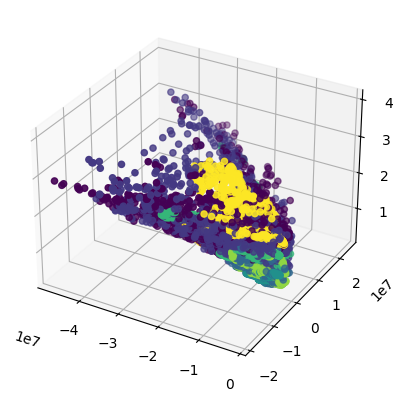

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(latent_X_train["x"],latent_X_train["y"], latent_X_train["z"], c=Y_train)

In [9]:
import plotly.express as px

In [10]:
px.scatter_3d(pd.DataFrame(latent_X_train.to_numpy(),columns=['x','y','z']), x='x', y='y', z='z',color=Y_train)

In [19]:
px.scatter_3d(pd.DataFrame(latent_X_test.to_numpy(),columns=['x','y','z']), x='x', y='y', z='z',color=Y_test)